<a href="https://colab.research.google.com/github/sajadamouei/classification-metabolomics/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification and metabolomics dataset

In [1]:
# datasets information
import pandas as pd
import requests
from io import BytesIO
import os

# download the data sets from Github
url = "https://github.com/sajadamouei/classification-metabolomics/blob/febca0b56691c042aa438a2cd6cd3bba12b1d41b/data/metabol_data.xlsx?raw=true"

# send a request to the URL
response = requests.get(url)

# check if the request was successful
if response.status_code == 200:

    excel_file = pd.ExcelFile(BytesIO(response.content))

    # write the content
    file_name = "metabol_data.xlsx"
    with open(file_name, "wb") as file:
        file.write(response.content)

    # get the path of the dataset
    file_path = os.path.abspath(file_name)

    # iterate through each sheet
    for sheet_name in excel_file.sheet_names:

        df = pd.read_excel(excel_file, sheet_name=sheet_name)

        # print sheet name
        print(f"Sheet Name: {sheet_name}")

        # print the number of samples
        num_samples = df.shape[0]
        print(f"Number of Samples: {num_samples}")

        # print the number of metabolites
        num_metabolites = df.shape[1] - 2
        print(f"Number of Metabolites: {num_metabolites}")

        # print a summary of the 'class' column
        print("Summary of 'classes' column:")
        print(df['class'].value_counts())

        print("\n" + "="*40 + "\n")

    # print the dataset's address
    print("The metabolomics data set has been downloaded from the Github repository to the address:", file_path)

else:
    print("Failed to download the file. Status code:", response.status_code)


Sheet Name: M1 Compounds ESI+
Number of Samples: 81
Number of Metabolites: 1922
Summary of 'classes' column:
class
1    54
0    27
Name: count, dtype: int64


Sheet Name: M1 Compounds ESI-
Number of Samples: 81
Number of Metabolites: 939
Summary of 'classes' column:
class
1    54
0    27
Name: count, dtype: int64


Sheet Name: M1 Compounds ESI+ and ESI-
Number of Samples: 81
Number of Metabolites: 2861
Summary of 'classes' column:
class
1    54
0    27
Name: count, dtype: int64


The metabolomics data set has been downloaded from the Github repository to the address: /content/metabol_data.xlsx


In [2]:
#!pip install tqdm > /dev/null 2>&1
#!pip install ipywidgets > /dev/null 2>&1
#!gdown -V > /dev/null 2>&1
#!gdown --folder url -O /content/data > /dev/null 2>&1

# Import necessary libraries and functions
import os
import shutil
import warnings
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from scipy.stats import norm

from sklearn.model_selection import (StratifiedKFold, cross_val_score, GridSearchCV,
                                     train_test_split)
from sklearn.metrics import (balanced_accuracy_score, classification_report,
                             matthews_corrcoef, confusion_matrix, mean_squared_error,
                             roc_curve, auc, roc_auc_score, accuracy_score,
                             f1_score, precision_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

In [3]:
############################################################################################# Plots
warnings.filterwarnings('ignore')

# Function to plot histograms for different performance metrics
def plot_histograms(auc_list, test_acc_list, mcc_list, bal_acc_list, model_name):
    metrics = [auc_list, test_acc_list, mcc_list, bal_acc_list]
    metric_names = ["AUC", "Test Accuracy", "MCC", "Balanced Accuracy"]

    plt.figure(figsize=(15, 10))

    # iterate over the metrics and plot histogram
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        plt.hist(metric, bins=20, edgecolor='black', alpha=0.7)
        plt.title(metric_names[i])
        plt.xlabel('Value')
        plt.ylabel('Frequency')

    plt.tight_layout()

    # Filename and saving the figure
    directory = "/content/report/plots"
    filename = os.path.join(directory, f"{model_name}.png")

    plt.savefig(filename, dpi=300)
    plt.close()

# Function to plot AUC with error bars for different models
def plot_auc_with_error_bars(results_df):
    labels = results_df["Model"]
    auc_means = results_df["AUC Mean"].values
    auc_stds = results_df["AUC Std"].values

    plt.figure(figsize=(14, 8))
    plt.bar(range(len(labels)), auc_means, yerr=auc_stds, align='center', alpha=0.7, ecolor='black', capsize=10)
    plt.ylabel('AUC')
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")

    # Annotations for better clarity
    for i, v in enumerate(auc_means):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=8, color='black')

    plt.tight_layout()
    plt.title('AUC with Error Bars for Different ML Model', y=1.05)

    plt.savefig("/content/report/auc_barplot_with_error_bars.png", bbox_inches='tight')
    plt.close()

# Function to zip the contents of the results folder
def zip_folder(folder_path, output_filename):
    shutil.make_archive(output_filename, 'zip', folder_path)

    return f"{output_filename}.zip"

# Configure pandas to display all rows
pd.set_option('display.max_rows', None)
# Ensure the directory for plots exists
os.makedirs("/content/report/plots", exist_ok=True)

########################################################################################### Load dataset
# Define a function to load the dataset from an Excel file
def load_dataset(sheet_name, remove_unknowns=True):
    path = file_path
    dataset = pd.read_excel(path, sheet_name=sheet_name, header=0)
    dataset = dataset.sample(frac=1, random_state=666).reset_index(drop=True)
    if remove_unknowns:
        dataset = dataset.loc[:, ~dataset.columns.str.startswith('unknown')]
    return dataset

# function to prepare the data for training
def prepare_data(dataset):
    train_label = dataset['class']
    train_data = dataset.drop(columns=[dataset.columns[0], dataset.columns[-1]])
    return train_data, train_label, dataset.columns.tolist()

# Function to get the dataset
def get_data(sheet_name, train_features):
    if train_features == 'Only known metabolites':
        dataset = load_dataset(sheet_name, remove_unknowns=True)
    else:
        dataset = load_dataset(sheet_name, remove_unknowns=False)
    return prepare_data(dataset)

# Select the data and feature types for the experiment
data = "M1 Compounds ESI+ and ESI-" # @param ["M1 Compounds ESI+", "M1 Compounds ESI-", "M1 Compounds ESI+ and ESI-"]
train_features = "All metabolites"

# Retrieve the prepared data for training
train_data, train_label, columns_list = get_data(data, train_features)

# Convert the training data and labels to NumPy arrays of type 'float32'
train_data = np.array(train_data).astype('float32')
train_label = np.array(train_label).astype('float32')

# Assign machine learning model parameter
ml_model = "All models"

models_dict = {
    "XGBoost": lambda: xgb.XGBClassifier(objective="binary:logistic", random_state=777),
    "Random Forest": lambda: RandomForestClassifier(random_state=777),
    "Support Vector Machine": lambda: SVC(probability=True, random_state=777),
    "MLP": lambda: MLPClassifier(random_state=777),
    "SGD": lambda: SGDClassifier(loss='log', random_state=777),
    "Logistic Regression": lambda: LogisticRegression(random_state=777),
    "k-NN": lambda: KNeighborsClassifier(n_neighbors=5),
    "Dummy Classifier MF": lambda: DummyClassifier(strategy='most_frequent', random_state=777),
    "Dummy Classifier U": lambda: DummyClassifier(strategy='uniform', random_state=777)
}

param_grid_search = {
    "XGBoost": {
        'max_depth': [3, 4],  # default 3
        'learning_rate': [0.1, 0.01],  # default 0.1
        'n_estimators': [100, 150],  # default 100
        'min_child_weight': [1, 2],  # default 1
        'gamma': [0, 0.1],  # default 0
        'subsample': [1.0],  # default 1
        'colsample_bytree': [1.0],  # default 1
    },

    "Random Forest": {
        'n_estimators': [100, 200],  # default 100
        'criterion': ['gini', 'entropy'],  # default 'gini'
        'max_depth': [None, 10],  # default None
        'min_samples_split': [2, 4],  # default 2
        'min_samples_leaf': [1],  # default 1
        'max_features': ['auto'],  # default 'auto'
        'bootstrap': [True]  # default True
    },
    "Support Vector Machine": {
        'C': [0.1, 1, 10],  # default 1.0
        'gamma': ['scale', 'auto'],  # default 'scale'
        'kernel': ['rbf']
    },
    "MLP": {
        'hidden_layer_sizes': [(100,), (50,50)],  # default (100,)
        'activation': ['logistic', 'relu'],  # default 'relu'
        'solver': ['adam', 'sgd'],  # default 'adam'
        'alpha': [0.0001, 0.001],  # default 0.0001
        'learning_rate': ['constant', 'adaptive'],  # default 'constant'
        'max_iter': [200],  # default 200
    },
    "SGD": {
        'loss': ['log'],  # default 'hinge'
        'penalty': ['l2', 'l1', 'elasticnet'],  # default 'l2'
        'alpha': [0.0001, 0.001],  # default 0.0001
        'learning_rate': ['optimal', 'adaptive'],  # default 'optimal'
    },
    "Logistic Regression": {
        'penalty': ['l2'],  # default penalty
        'C': [1.0, 0.1],  # default 1.0
        'solver': ['lbfgs', 'newton-cg'],  # default 'lbfgs'
        'max_iter': [100],  # default 100
        'class_weight': [None, 'balanced']  # default None
    },
    "k-NN": {
        'n_neighbors': [3, 5],  # default 5
        'weights': ['uniform', 'distance'],  # default 'uniform'
        'algorithm': ['auto', 'ball_tree'],  # default 'auto'
        'leaf_size': [20, 30],  # default 30
        'p': [2]  # default 2 (Euclidean distance)
    },
    "Dummy Classifier MF": {
        'strategy': ['most_frequent']
    },
    "Dummy Classifier U": {
        'strategy': ['uniform']
    }
}


# Initialize results DataFrame with specified columns
results_df = pd.DataFrame(columns=["Model", "AUC", "AUC SD", "MCC", "MCC SD","Precision", "Precision SD", "Sensitivity", "Sensitivity SD", "Specificity", "Specificity SD", "F1-score", "F1-score SD", "Balanced Accuracy", "Balanced Accuracy SD", "Test Accuracy", "Test Accuracy SD", "Train and test time"])
auc_raw_df = pd.DataFrame(columns=["Model","AUC Scores"])

# function for training and evaluating models
def train_and_evaluate(model_factory, x_data, y_data, model_name, column_list):

    t0 = time()
    # Lists to store metrics for each iteration
    mcc_list, bal_acc_list, cv_acc_list, specificity_list, sensitivity_list, precision_list, f1_score_list, test_acc_list, roc_auc_list = [], [], [], [], [], [], [], [], []
    auc_sc = None
    all_folds_feature_importance = []
    feature_names = column_list
    model = model_factory()

    # Set up stratified
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 777)

    # k-fold cross-validation
    for fold_idx, (train_index, test_index) in enumerate(skf.split(x_data, y_data)):
        # Split the data into training and testing sets for the current fold
        x_train_fold, x_test_fold = x_data[train_index], x_data[test_index]
        y_train_fold, y_test_fold = y_data[train_index], y_data[test_index]

        # grid search and nested k-fold
        grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid_search[model_name],
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=777),
                           scoring='balanced_accuracy',
                           verbose=1)

        grid_search.fit(x_train_fold, y_train_fold)
        new_model = grid_search.best_estimator_

        # Predict on the test fold and calculate accuracy
        if model_name == 'Support Vector Machine':
          new_model.probability = True
        y_pred = new_model.predict(x_test_fold)
        test_acc_list.append(accuracy_score(y_test_fold, y_pred))

        # Predict probabilities for the AUC
        y_score = new_model.predict_proba(x_test_fold)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_fold, y_score)

        # Calculate and store AUC, MCC, and balanced accuracy
        roc_auc_list.append(auc(fpr, tpr))
        mcc_list.append(matthews_corrcoef(y_test_fold, y_pred))
        bal_acc_list.append(balanced_accuracy_score(y_test_fold, y_pred))

        # Calculate precision, F1-score, specificity, and sensitivity
        precision = precision_score(y_test_fold, y_pred)
        f1_score_com = f1_score(y_test_fold, y_pred)
        precision_list.append(precision)
        f1_score_list.append(f1_score_com)

        tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred).ravel()
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)

        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)

    # Compile all the collected metrics into a summary dictionary
    auc_sc = {
        "Model": model_name,
        "AUC Scores":roc_auc_list
          }
    results = {
        "Model": model_name,
        "AUC": round(np.mean(roc_auc_list),4),
        "AUC SD": round(np.std(roc_auc_list), 4),
        "MCC": round(np.mean(mcc_list),4),
        "MCC SD": round(np.std(mcc_list), 4),
        "Precision": round(np.mean(precision_list),4),
        "Precision SD": round(np.std(precision_list), 4),
        "Sensitivity": round(np.mean(sensitivity_list),4),
        "Sensitivity SD": round(np.std(sensitivity_list), 4),
        "Specificity": round(np.mean(specificity_list),4),
        "Specificity SD": round(np.std(specificity_list), 4),
        "F1-score": round(np.mean(f1_score_list),4),
        "F1-score SD": round(np.std(f1_score_list), 4),
        "Balanced Accuracy": round(np.mean(bal_acc_list),4),
        "Balanced Accuracy SD": round(np.std(bal_acc_list), 4),
        "Test Accuracy": round(np.mean(test_acc_list),4),
        "Test Accuracy SD": round(np.std(test_acc_list), 4),
        "Train and test time": round(time()-t0, 2)
    }
    if model_name == 'Logistic Regression':
      new_model = grid_search.best_estimator_
      new_model.fit(x_data, y_data)

      coefficients = new_model.coef_[0]

      importance = pd.DataFrame({
      'Feature': feature_names,
      'Coefficient': coefficients,
      'Absolute Importance': np.abs(coefficients)
      })

      # Sorting the DataFrame by 'Absolute Importance'
      top_features = importance.sort_values(by='Absolute Importance', ascending=False)
      top_features.insert(0, '#', range(1, len(top_features) + 1))

      # Sorting by 'Coefficient' for the top positive and negative features
      top_positive = importance.sort_values(by='Coefficient', ascending=False)
      top_positive.insert(0, '#', range(1, len(top_positive) + 1))
      top_negative = importance.sort_values(by='Coefficient', ascending=True)
      top_negative.insert(0, '#', range(1, len(top_negative) + 1))

      # Saving the sorted top features to an Excel file without the index
      filename = "/content/report/top_features.xlsx"
      with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        top_features.to_excel(writer, sheet_name='Top features by Absolute Importance', index=False)
        top_positive.to_excel(writer, sheet_name='Top features Positive', index=False)
        top_negative.to_excel(writer, sheet_name='Top features Negative', index=False)


    # Generate histograms for the collected performance metrics
    plot_histograms(roc_auc_list, test_acc_list, mcc_list, bal_acc_list, model_name)
    return results, auc_sc

# train and evaluate models
if ml_model == "All models":

    for model_name, model in tqdm(models_dict.items(), desc="Status"):
        result, auc_scroe = train_and_evaluate(model, train_data, train_label, model_name, columns_list[1:-1])
        results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)
        auc_raw_df = pd.concat([auc_raw_df, pd.DataFrame([auc_scroe])], ignore_index=True)

# Save the aggregated results to an Excel file
results_df.to_excel("/content/report/results.xlsx", index=False)

# Package all results and plots into a downloadable zip file
zip_path = zip_folder("/content/report", "/content/report")
# Print out the path to the zipped results
print(f"The results of this experiment, as well as the plots, are available for download in a zipped folder at the address: {zip_path}")

Status:   0%|          | 0/9 [00:00<?, ?it/s]

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 fold

In [ ]:
!pip install adjustText

The plot of AUC Mean and SD across 10-fold cross-validation of  M1 Compounds ESI+ and ESI- data set


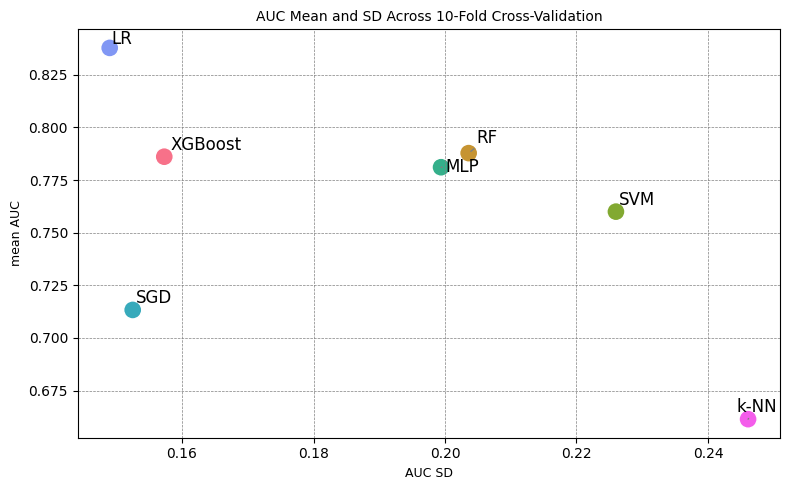

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
from adjustText import adjust_text

# read file
df_con = pd.read_excel('/content/report/results.xlsx')

# remove dummy classifirers rows
df_con = df_con[~df_con['Model'].isin(['Dummy Classifier MF', 'Dummy Classifier U'])]

# make shorter the models name for the plot
df_con['Model'] = df_con['Model'].replace({
    'Random Forest': 'RF',
    'Support Vector Machine': 'SVM',
    'Logistic Regression': 'LR'
})

# generate a distinct color palette for each model
models = df_con['Model'].unique()
color_palette = sns.color_palette("husl", len(models))

model_color_palette = {model: color for model, color in zip(models, color_palette)}

plt.figure(figsize=(8, 5))

# generate the plot
ax = sns.scatterplot(x="AUC SD", y="AUC", hue="Model", palette=model_color_palette, data=df_con, s=170, legend=None)

# adding the grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# customize the plot
plt.title('AUC Mean and SD Across 10-Fold Cross-Validation', fontsize=10)
plt.xlabel('AUC SD', fontsize=9)
plt.ylabel('mean AUC', fontsize=9)

# adjust_text
texts = []
for index, row in df_con.iterrows():
    texts.append(plt.text(row['AUC SD'], row['AUC'], row['Model'], fontsize=12))

# automatically adjust text positions
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.tight_layout()

# save the plot as a PDF file
plt.savefig('/content/auc_plot.pdf')

print('The plot of AUC Mean and SD across 10-fold cross-validation of ', data, 'data set')

plt.show()